In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import numpy as np
import os.path as osp

from geo_tool import Point_Cloud

from tf_lab.nips.helper import pclouds_centered_and_half_sphere, center_pclouds_in_unit_sphere, pclouds_with_zero_mean_in_unit_sphere
from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence, minimum_mathing_distance

In [11]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Parameters
class_name = 'chair'
n_pc_samples = 2048
do_mmd = True
do_jsd = False

# For JSD
cmp_in_sphere = True
voxel_resolution = 28
use_uniform_prior = False

# For MMD
reduce_gt = 1000
batch_size = 1000

def identity(x):
    return x

if do_mmd:    
    pc_normalizer = pclouds_with_zero_mean_in_unit_sphere
elif do_jsd:
    pc_normalizer = identity
#     pc_normalizer = pclouds_with_zero_mean_in_unit_sphere

In [15]:
# Load Wu Data, compute grid variable.
top_in_data = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/mit_wu_isosurface_extracted/'
wu_data = np.load(osp.join(top_in_data, class_name + '.npz'))
wu_data = pc_normalizer(wu_data[wu_data.keys()[0]])
assert(wu_data.shape[1] == n_pc_samples)

if do_jsd:
    _, wu_grid_var = entropy_of_occupancy_grid(wu_data, voxel_resolution, in_sphere=cmp_in_sphere)
    if use_uniform_prior:
        wu_grid_var += 1

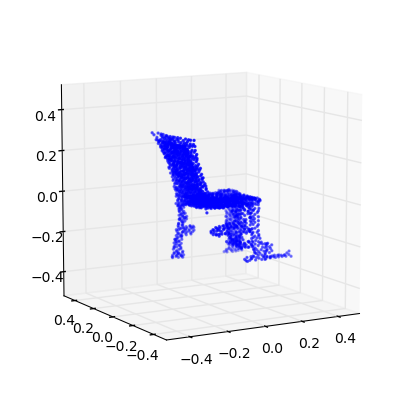

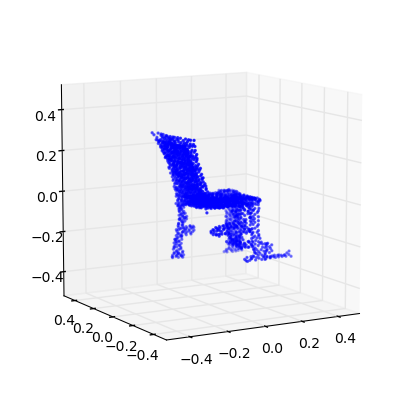

In [22]:
Point_Cloud(wu_data[115]).plot()

In [23]:
# # Load GT Data
# syn_id = snc_category_to_synth_id()[class_name]
# in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
# train_data = in_data['train'].point_clouds
# test_data = in_data['test'].point_clouds
# val_data = in_data['val'].point_clouds
# # all_pclouds = pc_normalizer(np.vstack([train_data, test_data, val_data]))
# all_pclouds = pc_normalizer(train_data)

# Load Ground-Truth Train Data.
top_gt_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/gt_data/'
gt_train_file = osp.join(top_gt_dir, class_name + '_train.npz')
gt_train_data = np.load(gt_train_file)  
gt_train_data = pc_normalizer(gt_train_data[gt_train_data.keys()[0]])

# Load Ground-Truth Test Data.
gt_test_file = osp.join(top_gt_dir, class_name + '_test.npz')
gt_test_data = np.load(gt_test_file)  
gt_test_data = pc_normalizer(gt_test_data[gt_test_data.keys()[0]])

gt_train_file = osp.join(top_gt_dir, class_name + '_train.npz')
gt_train_data = np.load(gt_train_file)  
gt_train_data = pc_normalizer(gt_train_data[gt_train_data.keys()[0]])

gt_cmp_data = gt_train_data

In [25]:
if do_jsd:
    _, gt_grid_var = entropy_of_occupancy_grid(gt_cmp_data, voxel_resolution, in_sphere=cmp_in_sphere)
    if use_uniform_prior:
        gt_grid_var += 1
    res = jensen_shannon_divergence(wu_grid_var, gt_grid_var)
    print res

0.161391607916


In [12]:
if do_mmd:
    if reduce_gt is not None:
        gt_cmp_data = gt_cmp_data[:reduce_gt]
            
    res = minimum_mathing_distance(wu_data[:len(gt_cmp_data)], gt_cmp_data, batch_size, normalize=True, verbose=True, use_sqrt=True)[0]
    print res

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
0.0666976
